In [1]:
import glob
import numpy as np
import pandas as pd
import os
import time
import math
import numpy as np
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
from torch import optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, random_split
import sys
sys.path.append('..')

from word_cnn.model import TCN
from MIDI.PRETTY_MIDI.pretty_midi_tokenization import PrettyMidiTokenizer, SILENCE_TOKEN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width',1000)


DIRECTORY_PATH = ''
DATASET_PATH = os.path.join(DIRECTORY_PATH, 'dataset')
MODEL_PATH = os.path.join(DIRECTORY_PATH, 'model/generated_model.pth')
RESULTS_PATH = os.path.join(DIRECTORY_PATH, 'results')


EPOCHS = 500 # 500
LEARNING_RATE = 4
BATCH_SIZE = 2
TRAIN_MODEL = True
SPLIT_DATASET = True


C:\Users\Gianni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Assumptions:
Sequences described as input_#.mid and output_#.mid in the corresponding folders
'''

input_filenames = glob.glob(os.path.join(DATASET_PATH, 'input/*.MID'))
print('Number of input files:', len(input_filenames))

output_filenames = glob.glob(os.path.join(DATASET_PATH, 'output/*.MID'))
print('Number of output files:', len(output_filenames))


for i, (in_file, out_file) in enumerate(zip(input_filenames, output_filenames)):

    in_file_name = os.path.basename(in_file)
    out_file_name = os.path.basename(out_file)
    print(f'\n\n{i + 1}: {in_file_name} -> {out_file_name}')

    INPUT_TOK = PrettyMidiTokenizer(in_file)
    print(f'\nNumber of input bars: {INPUT_TOK.num_bars}')
    print(f'Number of input sequences: {len(INPUT_TOK.sequences)}')
    print(f'Input sequence length: {len(INPUT_TOK.sequences[0])}')
    print(f'Input vocabulars size: {len(INPUT_TOK.VOCAB)}')

    OUTPUT_TOK = PrettyMidiTokenizer(out_file)
    print(f'\nNumber of output bars: {OUTPUT_TOK.num_bars}')
    print(f'Number of output sequences: {len(OUTPUT_TOK.sequences)}')
    print(f'Output sequence length: {len(OUTPUT_TOK.sequences[0])}')
    print(f'Output vocabulars size: {len(OUTPUT_TOK.VOCAB)}')

    # force the sequences to be the same length
    min_length = min(len(INPUT_TOK.sequences), len(OUTPUT_TOK.sequences))
    INPUT_TOK.sequences = INPUT_TOK.sequences[:min_length]
    OUTPUT_TOK.sequences = OUTPUT_TOK.sequences[:min_length]
    print(f'\nNumber of sequences after truncation: {len(INPUT_TOK.sequences)}, {len(OUTPUT_TOK.sequences)}')

Number of input files: 1
Number of output files: 1


1: drum_excited.MID -> bass_example.MID

Number of input bars: 24
Number of input sequences: 20
Input sequence length: 192
Input vocabulars size: 13

Number of output bars: 33
Number of output sequences: 29
Output sequence length: 192
Output vocabulars size: 30

Number of sequences after truncation: 20, 20


In [3]:
# Create the dataset
dataset = TensorDataset(torch.LongTensor(INPUT_TOK.sequences).to(device),
                        torch.LongTensor(OUTPUT_TOK.sequences).to(device))

if SPLIT_DATASET:
    # Split the dataset into training, evaluation and test sets
    train_set, eval_set, test_set = random_split(dataset, [0.6, 0.2, 0.2])

    # Create the dataloaders
    train_sampler = RandomSampler(train_set)          
    train_dataloader = DataLoader(train_set, sampler=train_sampler, batch_size=BATCH_SIZE)

    eval_sampler = RandomSampler(eval_set)
    eval_dataloader = DataLoader(eval_set, sampler=eval_sampler, batch_size=BATCH_SIZE)

    test_sampler = RandomSampler(test_set)
    test_dataloader = DataLoader(test_set, sampler=test_sampler, batch_size=BATCH_SIZE)

else:
    train_set = dataset
    train_sampler = RandomSampler(train_set)          
    train_dataloader = DataLoader(train_set, sampler=train_sampler, batch_size=BATCH_SIZE)

    eval_dataloader = []
    test_dataloader = []

print(f'Train set size: {len(train_set)}')
print(f'Evaluation set size: {len(eval_set)}')
print(f'Test set size: {len(test_set)}')


Train set size: 12
Evaluation set size: 4
Test set size: 4


C:\Users\Gianni\AppData\Local\Temp\ipykernel_21948\1074408545.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  dataset = TensorDataset(torch.LongTensor(INPUT_TOK.sequences).to(device),


In [4]:
# Set the hyperparameters
SEED = 1111 
OUTPUT_VOCAB_SIZE = len(OUTPUT_TOK.VOCAB)
EMBEDDING_SIZE = 20 # size of word embeddings -> Embedding() is used to encode input token into [192, 20] vectors (see model.py)
LEVELS = 7
HIDDEN_UNITS = 192
NUM_CHANNELS = [HIDDEN_UNITS] * (LEVELS - 1) + [EMBEDDING_SIZE]
GRADIENT_CLIP = 0.35


# balance the loss function by assigning a weight to each token related to its frequency
LOSS_WEIGTHS = torch.ones([OUTPUT_VOCAB_SIZE], dtype=torch.float)
for i, weigth in enumerate(OUTPUT_TOK.tokens_weights):
    LOSS_WEIGTHS[i] = 1 - weigth
    # print(f'{OUTPUT_TOK.VOCAB.idx2word[i]}: {LOSS_WEIGTHS[i]}')

# create the model
model = TCN(input_size = EMBEDDING_SIZE, 
            output_size = OUTPUT_VOCAB_SIZE, 
            num_channels = NUM_CHANNELS, 
            dropout = 0.45, 
            emb_dropout = 0.25, 
            kernel_size = 3, 
            tied_weights = False) # tie encoder and decoder weights (legare)


# May use adaptive softmax to speed up training
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss(weight = LOSS_WEIGTHS)
optimizer = getattr(optim, 'SGD')(model.parameters(), lr=LEARNING_RATE)


In [5]:
BAR_LENGTH = INPUT_TOK.BAR_LENGTH

def epoch_step(dataloader, mode):

    if mode == 'train':
        model.train()
    else:
        model.eval() # disable dropout
        
    total_loss = 0

    # iterate over the training data
    for batch_idx, (data, targets) in enumerate(dataloader):

        batch_idx += 1

        # mask the last bar of the input data 
        batch_size = data.size(0)
        data_masked = torch.cat((data[:, :BAR_LENGTH*3], torch.ones([batch_size, BAR_LENGTH], dtype=torch.long)), dim = 1)

        # reset model gradients to zero
        optimizer.zero_grad()

        # make the prediction
        output = model(data_masked)

        # flatten the output sequence
        # NB: the size -1 is inferred from other dimensions
        # NB: contiguous() is used to make sure the tensor is stored in a contiguous chunk of memory, necessary for view() to work
        final_target = targets.contiguous().view(-1)
        final_output = output.contiguous().view(-1, OUTPUT_VOCAB_SIZE)

        # calculate the loss
        loss = criterion(final_output, final_target)

        # calculate the gradients
        loss.backward()

        if GRADIENT_CLIP > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)

        # update the weights
        optimizer.step()

        total_loss += loss.data.item()

    return total_loss / len(dataloader)


In [6]:
best_loss = 1e8
best_model_epoch = 0
eval_losses = []
train_losses = []
lr = LEARNING_RATE


if TRAIN_MODEL:
    
    for epoch in range(1, EPOCHS+1):

        start_time = time.time()

        train_loss = epoch_step(train_dataloader, 'train')


        if SPLIT_DATASET:
            eval_loss = epoch_step(eval_dataloader, 'eval')

            # Save the model if the validation loss is the best we've seen so far.
            if eval_loss < best_loss:
                torch.save(model, MODEL_PATH)
                best_loss = eval_loss
                best_model_epoch = epoch + 1

            # Anneal the learning rate if the validation loss plateaus
            if epoch > 5 and eval_loss >= max(eval_losses[-5:]):
                lr = lr / 2.
                if lr < 0.1:
                    lr = 2
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr


        else:
            eval_loss = 0

            # Save the model if the validation loss is the best we've seen so far.
            if train_loss < best_loss:
                torch.save(model, MODEL_PATH)
                best_loss = train_loss
                best_model_epoch = epoch + 1


        eval_losses.append(eval_loss)
        train_losses.append(train_loss)


        # print the loss and the progress
        elapsed = time.time() - start_time
        print('| epoch {:3d}/{:3d} | lr {:02.5f} | ms/epoch {:5.5f} | train_loss {:5.2f} | eval_loss {:5.2f}' \
                .format(epoch, EPOCHS, lr, elapsed * 1000, train_loss, eval_loss))
        
    
    if TRAIN_MODEL:
        print('\n\n TRAINING FINISHED:\n\n\tBest Loss: {:5.2f}\tBest Model saved at epoch: {:3d}' \
              .format(best_loss, best_model_epoch))

| epoch   1/500 | lr 4.00000 | ms/epoch 958.65893 | train_loss  3.05 | eval_loss  2.93
| epoch   2/500 | lr 4.00000 | ms/epoch 727.10443 | train_loss  2.81 | eval_loss  2.74
| epoch   3/500 | lr 4.00000 | ms/epoch 690.06920 | train_loss  2.80 | eval_loss  2.76
| epoch   4/500 | lr 4.00000 | ms/epoch 719.91587 | train_loss  2.79 | eval_loss  2.73
| epoch   5/500 | lr 4.00000 | ms/epoch 753.07107 | train_loss  2.79 | eval_loss  2.72
| epoch   6/500 | lr 4.00000 | ms/epoch 928.99823 | train_loss  2.78 | eval_loss  2.73
| epoch   7/500 | lr 4.00000 | ms/epoch 1377.65098 | train_loss  2.79 | eval_loss  2.71
| epoch   8/500 | lr 4.00000 | ms/epoch 1197.96085 | train_loss  2.79 | eval_loss  2.71
| epoch   9/500 | lr 4.00000 | ms/epoch 1062.23297 | train_loss  2.79 | eval_loss  2.70
| epoch  10/500 | lr 4.00000 | ms/epoch 1111.03654 | train_loss  2.81 | eval_loss  2.66
| epoch  11/500 | lr 4.00000 | ms/epoch 1115.21363 | train_loss  2.78 | eval_loss  2.71
| epoch  12/500 | lr 4.00000 | ms/epoc

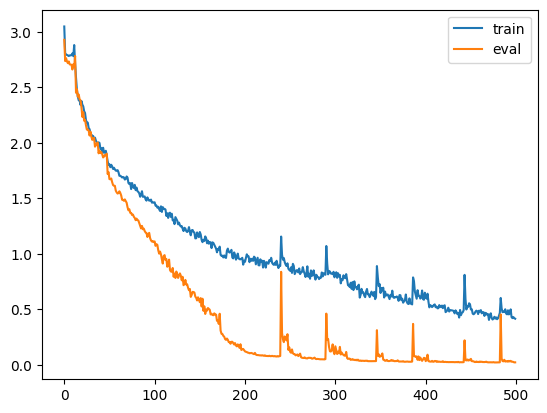

<Figure size 640x480 with 0 Axes>

In [7]:
# plot the losses over the epochs 
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(eval_losses, label='eval')
plt.legend()
plt.show()

# save images
plt.savefig(os.path.join(RESULTS_PATH, 'losses.png'))

In [8]:
# Load the best saved model.
with open(MODEL_PATH, 'rb') as f:
    model = torch.load(f)

# get a sample from the test set
if SPLIT_DATASET:
    samples, targets = next(iter(test_dataloader))
else:
    samples, targets = next(iter(train_dataloader))

# Get the last sequence from the batch and unsqueeze it to add a batch dimension.
sample = samples[-1].unsqueeze(0)

# Mask the last bar of the input data.
sample = torch.cat((sample[:, :BAR_LENGTH*3], torch.ones([1, BAR_LENGTH], dtype=torch.long)), dim = 1)

# Make the prediction.
prediction = model(sample)
prediction = prediction.contiguous().view(-1, OUTPUT_VOCAB_SIZE)

# Get the predicted tokens.
predicted_tokens = torch.argmax(prediction, 1)

# Get the predicted sequence.
predicted_sequence = predicted_tokens.cpu().numpy().tolist()

# Convert the predicted sequence to MIDI.
out_file_path = os.path.join(RESULTS_PATH, 'predicted.mid')
midi, pitch_ticks_list =  OUTPUT_TOK.tokens_to_midi(predicted_sequence, out_file_path) # midi is a pretty midi object

# check 
predicted_sequence_string = []
for id in predicted_sequence:
    predicted_sequence_string.append(OUTPUT_TOK.VOCAB.idx2word[id])
print(predicted_sequence_string)
print(pitch_ticks_list)

['50S', '43S', '43', '43', '43', '43', '43', '43', 'O', '43S', '43S', '43', '43', '47S', '47', '47', '47', '47', '47', '47', '47S', '47S', '47', '47', 'O', '50S', '50', '50S', '50', '50', '50', 'O', 'O', '50S', '50', '50', 'O', '53S', '53S', '53', 'O', 'O', '52', 'O', 'O', '50S', '50', '50', 'O', '43S', '43', '43', '43', '43', '43', 'O', 'O', '43S', '43', '43', 'O', '47S', '47', '47', '47', '47', '47', '47', 'O', '47', '47S', 'O', 'O', 'O', '50', '50', '50', '50', '50', 'O', '50S', '50S', '50', '50', '53S', '53', '53', '53', 'O', '57', '52', '52', 'O', 'O', '50S', 'O', 'O', 'O', '43', '43', '43', '43', '43', 'O', 'O', '43S', '43', '43', 'O', '47S', '47', '47', '47', '47', 'O', 'O', '47S', '47', '47', 'O', '50S', '50', '50', '50', '50', '50', 'O', 'O', '50S', '50', '50', '50', '53S', '53S', '53', 'O', '52S', '52', '52', 'O', 'O', '50S', '50', 'O', '43S', '43', '43', '43', '43', '43', '43', 'O', 'O', '43', '43', 'O', 'O', '47S', '47', '47', '47', '52', '52', 'O', '52S', '47', '47', 'O', 